In [ ]:
!pip install pyspark

In [ ]:
!pip install wordcloud matplotlib

In [ ]:
from pyspark.sql import SparkSession
# Create Spark session
spark = SparkSession.builder \
    .appName("Spark EDA") \
    .getOrCreate()

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql.functions import  regexp_extract
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import  date_format
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.corpus import stopwords
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col, trim, lower

## Preparing Dataset

### Dataset 1

In [ ]:
df2 = spark.read.csv("hdfs://localhost:9000/tweetsdata/Covid-19 Twitter Dataset (Apr-Jun 2020).csv", header=True, inferSchema=True)
df2.printSchema()
df2.show(10)

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- source: string (nullable = true)
 |-- original_text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- original_author: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- user_mentions: string (nullable = true)
 |-- place: string (nullable = true)
 |-- clean_tweet: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- neg: string (nullable = true)
 |-- neu: string (nullable = true)
 |-- pos: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+----------+--------------------+--------------------+----------+--------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+--------+-----+-----+-----+---------+
|                  id|created_at|              source|   

In [ ]:
df2=df2.select("created_at","original_text","sentiment")
df2.show()

+----------+--------------------+---------+
|created_at|       original_text|sentiment|
+----------+--------------------+---------+
|2020-04-19|RT @GlblCtzn: .@p...|      pos|
|2020-04-19|RT @OGSG_Official...|      pos|
|2020-04-19|RT @AdvoBarryRoux...|      pos|
|2020-04-19|RT @MobilePunch: ...|     NULL|
|        en|                 0.0|     NULL|
|2020-04-19|My Condolences to...|      neu|
|2020-04-19|RT @DrJMZimmerman...|      neu|
|2020-04-19|Taiwan's Vice-Pre...|      neg|
|2020-04-19|RT @morethanmySLE...|      neg|
|2020-04-19|Horrible tragedy ...|      neu|
|2020-04-19|@TahirsyeedK @sag...|      neu|
|2020-04-19|RT @JoeNBC: Janua...|      neu|
|2020-04-19|RT @BuckSexton: D...|     NULL|
|        en|                19.0|     NULL|
|2020-04-19|RT @KatiePhang: “...|      neg|
|2020-04-19|RT @ClevelandClin...|      pos|
|2020-04-19|RT @SaharaReporte...|      neu|
|2020-04-19|RT @JoeConchaTV: ...|      neg|
|2020-04-19|RT @OIC_IPHRC: 1/...|      neg|
|2020-04-19|RT @Always_a_Yes:...

In [ ]:
# Rename a single column
df2= df2.withColumnRenamed("original_text", "tweet")
df2.show(5)

+----------+--------------------+---------+
|created_at|               tweet|sentiment|
+----------+--------------------+---------+
|2020-04-19|RT @GlblCtzn: .@p...|      pos|
|2020-04-19|RT @OGSG_Official...|      pos|
|2020-04-19|RT @AdvoBarryRoux...|      pos|
|2020-04-19|RT @MobilePunch: ...|     NULL|
|        en|                 0.0|     NULL|
+----------+--------------------+---------+
only showing top 5 rows



In [ ]:
df2=df2.na.drop(subset=['sentiment','tweet'])
df2.show(truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------+---------+
|created_at|tweet                                                                                                                                       |sentiment|
+----------+--------------------------------------------------------------------------------------------------------------------------------------------+---------+
|2020-04-19|RT @GlblCtzn: .@priyankachopra is calling on leaders to help protect refugees from COVID-19 by providing them with quality health care and… |pos      |
|2020-04-19|RT @OGSG_Official: OGUN STATE SUPPORT FOR CBN-NIRSAL COVID-19 TARGETED CREDIT FACILITY - TCF https://t.co/koWBQECoQq                        |pos      |
|2020-04-19|RT @AdvoBarryRoux: These 5 police officials based at Namahadi police station were busy drinking liquor at a certain tavern whilst on duty,… |pos      |
|2020-04-19|My C

In [ ]:
print("The number of tweets: ",df2.count())

The number of tweets:  108887


### Dataset 2

In [ ]:
df3 = spark.read.csv("hdfs://localhost:9000/tweetsdata/Covid-19 Twitter Dataset (Apr-Jun 2021).csv", header=True, inferSchema=True)
df3.printSchema()
df3.show(10)

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- source: string (nullable = true)
 |-- original_text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- original_author: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- user_mentions: string (nullable = true)
 |-- place: string (nullable = true)
 |-- clean_tweet: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- neg: string (nullable = true)
 |-- neu: string (nullable = true)
 |-- pos: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+----------+--------------------+--------------------+--------+--------------------+---------------+----------------+------------+--------------------+-------+--------------------+--------+-----+-----+-----+---------+
|                  id|created_at|              source|       original_t

In [ ]:
df3=df3.select("original_text","sentiment","created_at")
df3.show()

+--------------------+---------+----------+
|       original_text|sentiment|created_at|
+--------------------+---------+----------+
|RT @VP: The U.S. ...|      pos|2021-04-26|
|RT @JackPosobiec:...|      neg|2021-04-26|
|RT @timmy315: Hi ...|      neu|2021-04-26|
|RT @itsaadee: Pra...|      neg|2021-04-26|
|Rapid Investment ...|      pos|2021-04-26|
|RT @GopiKishorRaj...|     NULL|2021-04-26|
|                NULL|     NULL|      NULL|
|                NULL|     NULL|      NULL|
|               140.0|     NULL|        en|
|RT @VPSecretariat...|      neu|2021-04-26|
|COVID-19: Legal a...|      pos|2021-04-26|
|6-Ft Rule Doesn't...|      neg|2021-04-26|
|Please be aware, ...|      neu|2021-04-26|
|RT @ShlokamS: Som...|     NULL|2021-04-26|
|                NULL|     NULL|   #SOSIYC|
|                NULL|     NULL|      NULL|
|                NULL|     NULL|      NULL|
|                NULL|     NULL|      NULL|
|              2509.0|     NULL|        en|
|RT @nramind: Watc...|      neu|

In [ ]:
df3= df3.withColumnRenamed("original_text", "tweet")
df3.show(5)


+--------------------+---------+----------+
|               tweet|sentiment|created_at|
+--------------------+---------+----------+
|RT @VP: The U.S. ...|      pos|2021-04-26|
|RT @JackPosobiec:...|      neg|2021-04-26|
|RT @timmy315: Hi ...|      neu|2021-04-26|
|RT @itsaadee: Pra...|      neg|2021-04-26|
|Rapid Investment ...|      pos|2021-04-26|
+--------------------+---------+----------+
only showing top 5 rows



In [ ]:
df3=df3.na.drop(subset=['created_at','tweet','sentiment'])
df3.show()

+--------------------+---------+----------+
|               tweet|sentiment|created_at|
+--------------------+---------+----------+
|RT @VP: The U.S. ...|      pos|2021-04-26|
|RT @JackPosobiec:...|      neg|2021-04-26|
|RT @timmy315: Hi ...|      neu|2021-04-26|
|RT @itsaadee: Pra...|      neg|2021-04-26|
|Rapid Investment ...|      pos|2021-04-26|
|RT @VPSecretariat...|      neu|2021-04-26|
|COVID-19: Legal a...|      pos|2021-04-26|
|6-Ft Rule Doesn't...|      neg|2021-04-26|
|Please be aware, ...|      neu|2021-04-26|
|RT @nramind: Watc...|      neu|2021-04-26|
|RT @DailyMonitor:...|      neg|2021-04-26|
|13-year-old Bramp...|      neu|2021-04-26|
|RT @GlobalNationa...|      neu|2021-04-26|
|RT @nytimes: Brea...|      pos|2021-04-26|
|RT @BoSnerdley: F...|      neg|2021-04-26|
|RT @urstrulyMahes...|      neg|2021-04-26|
|"And the racism a...|      neg|2021-04-26|
|@ClaudiaSchoene3 ...|      neu|2021-04-26|
|RT @timesofindia:...|      neu|2021-04-26|
|The new COVID-19 ...|      pos|

In [ ]:
print("The number of tweets: ",df3.count())

The number of tweets:  104056


### Dataset 3

In [ ]:
df4 = spark.read.csv("hdfs://localhost:9000/tweetsdata/Covid-19 Twitter Dataset (Aug-Sep 2020).csv", header=True, inferSchema=True)
df4.printSchema()
df4.show(10)

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- source: string (nullable = true)
 |-- original_text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- original_author: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- user_mentions: string (nullable = true)
 |-- place: string (nullable = true)
 |-- clean_tweet: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- neg: string (nullable = true)
 |-- neu: string (nullable = true)
 |-- pos: string (nullable = true)
 |-- sentiment: string (nullable = true)

+--------------------+----------+--------------------+--------------------+-------------+--------------------+-------------+--------------------+--------------------+--------------------+---------------+--------------------+--------+-----+-----+----+---------+
|                  id|created_at|              so

In [ ]:
df4=df4.select('created_at','original_text','sentiment')
df4.show()

+--------------------+--------------------+---------+
|          created_at|       original_text|sentiment|
+--------------------+--------------------+---------+
|          2020-08-20|RT @RobertAlai: 9...|      neu|
|          2020-08-20|RT @cnnphilippine...|      neu|
|          2020-08-20|RT @latestly: #Si...|     NULL|
|                  en|                 0.0|     NULL|
|          2020-08-20|Lending Club loan...|     NULL|
|                  en|                13.0|     NULL|
|          2020-08-20|RT @OpIndia_com: ...|      neu|
|          2020-08-20|"RT @balloon_want...|      neg|
|          2020-08-20|RT @alwayswithyou...|      neu|
|          2020-08-20|RT @EdinburghTram...|     NULL|
|                  en|                 2.0|     NULL|
|          2020-08-20|RT @SynergyMobile...|     NULL|
|                  en|               786.0|     NULL|
|          2020-08-20|RT @larryelder: D...|     NULL|
|                NULL|                NULL|     NULL|
|000 American COVI...|      

In [ ]:
df4= df4.withColumnRenamed("original_text", "tweet")
df4.show(5)

+----------+--------------------+---------+
|created_at|               tweet|sentiment|
+----------+--------------------+---------+
|2020-08-20|RT @RobertAlai: 9...|      neu|
|2020-08-20|RT @cnnphilippine...|      neu|
|2020-08-20|RT @latestly: #Si...|     NULL|
|        en|                 0.0|     NULL|
|2020-08-20|Lending Club loan...|     NULL|
+----------+--------------------+---------+
only showing top 5 rows



In [ ]:
df4=df4.na.drop(subset=['tweet','sentiment'])
df4.show()

+----------+--------------------+---------+
|created_at|               tweet|sentiment|
+----------+--------------------+---------+
|2020-08-20|RT @RobertAlai: 9...|      neu|
|2020-08-20|RT @cnnphilippine...|      neu|
|2020-08-20|RT @OpIndia_com: ...|      neu|
|2020-08-20|"RT @balloon_want...|      neg|
|2020-08-20|RT @alwayswithyou...|      neu|
|2020-08-20|RT @DWUhlfelderLa...|      neu|
|2020-08-20|RT @BylineTimes: ...|      neu|
|2020-08-20|RT @kuyaaisko: PH...|      neu|
|2020-08-20|RT @crikey_news: ...|      pos|
|2020-08-20|'Silent spreaders...|      neg|
|2020-08-20|RT @Jasfher: WHO:...|      pos|
|2020-08-20|RT @sonaliranade:...|      neg|
|2020-08-20|"RT @SheenaParish...|      neg|
|2020-08-20|RT @kdramafairy: ...|      neg|
|2020-08-20|RT @kleine_zalze:...|      pos|
|2020-08-20|RT @AlexBerenson:...|      pos|
|2020-08-20|"RT @TonyGreyMan:...|      neg|
|2020-08-20|"RT @ReviewReligi...|      neg|
|2020-08-20|RT @CricCrazyJohn...|      neu|
|2020-08-20|RT @Showsha_in: #...

In [ ]:
print("The number of tweets: ", df4.count())

The number of tweets:  88827


### Combining Datasets

In [ ]:
df5=df2.union(df3)
df5.count()

212943

In [ ]:
df6=df5.union(df4)
df6.count()

301770

In [ ]:
df6.show(10)

+----------+--------------------+---------+
|created_at|               tweet|sentiment|
+----------+--------------------+---------+
|2020-04-19|RT @GlblCtzn: .@p...|      pos|
|2020-04-19|RT @OGSG_Official...|      pos|
|2020-04-19|RT @AdvoBarryRoux...|      pos|
|2020-04-19|My Condolences to...|      neu|
|2020-04-19|RT @DrJMZimmerman...|      neu|
|2020-04-19|Taiwan's Vice-Pre...|      neg|
|2020-04-19|RT @morethanmySLE...|      neg|
|2020-04-19|Horrible tragedy ...|      neu|
|2020-04-19|@TahirsyeedK @sag...|      neu|
|2020-04-19|RT @JoeNBC: Janua...|      neu|
+----------+--------------------+---------+
only showing top 10 rows



## Data Transformation

In [ ]:
label_expr = (when(col('sentiment') == 'pos', 1)
              .when(col('sentiment') == 'neg', 0)
              .when(col('sentiment') == 'neu', 2)
              .otherwise(None))

df= df6.withColumn('label', label_expr)
df=df.dropna()
df.show()

+----------+--------------------+---------+-----+
|created_at|               tweet|sentiment|label|
+----------+--------------------+---------+-----+
|2020-04-19|RT @GlblCtzn: .@p...|      pos|    1|
|2020-04-19|RT @OGSG_Official...|      pos|    1|
|2020-04-19|RT @AdvoBarryRoux...|      pos|    1|
|2020-04-19|My Condolences to...|      neu|    2|
|2020-04-19|RT @DrJMZimmerman...|      neu|    2|
|2020-04-19|Taiwan's Vice-Pre...|      neg|    0|
|2020-04-19|RT @morethanmySLE...|      neg|    0|
|2020-04-19|Horrible tragedy ...|      neu|    2|
|2020-04-19|@TahirsyeedK @sag...|      neu|    2|
|2020-04-19|RT @JoeNBC: Janua...|      neu|    2|
|2020-04-19|RT @KatiePhang: “...|      neg|    0|
|2020-04-19|RT @ClevelandClin...|      pos|    1|
|2020-04-19|RT @SaharaReporte...|      neu|    2|
|2020-04-19|RT @JoeConchaTV: ...|      neg|    0|
|2020-04-19|RT @OIC_IPHRC: 1/...|      neg|    0|
|2020-04-19|@ronnieClarke69 @...|      neu|    2|
|2020-04-19|RT @victorialwalt...|      neu|    2|


In [ ]:
df=df.drop("sentiment")
df.show()

+----------+--------------------+-----+
|created_at|               tweet|label|
+----------+--------------------+-----+
|2020-04-19|RT @GlblCtzn: .@p...|    1|
|2020-04-19|RT @OGSG_Official...|    1|
|2020-04-19|RT @AdvoBarryRoux...|    1|
|2020-04-19|My Condolences to...|    2|
|2020-04-19|RT @DrJMZimmerman...|    2|
|2020-04-19|Taiwan's Vice-Pre...|    0|
|2020-04-19|RT @morethanmySLE...|    0|
|2020-04-19|Horrible tragedy ...|    2|
|2020-04-19|@TahirsyeedK @sag...|    2|
|2020-04-19|RT @JoeNBC: Janua...|    2|
|2020-04-19|RT @KatiePhang: “...|    0|
|2020-04-19|RT @ClevelandClin...|    1|
|2020-04-19|RT @SaharaReporte...|    2|
|2020-04-19|RT @JoeConchaTV: ...|    0|
|2020-04-19|RT @OIC_IPHRC: 1/...|    0|
|2020-04-19|@ronnieClarke69 @...|    2|
|2020-04-19|RT @victorialwalt...|    2|
|2020-04-19|RT @keithgerein: ...|    0|
|2020-04-19|@jettaboldt @SkyN...|    2|
|2020-04-19|RT @JoeNBC: The m...|    2|
+----------+--------------------+-----+
only showing top 20 rows



In [ ]:
print('Tweets:',df.count())

Tweets: 193750


## Drop Nulls

In [ ]:
df=df.dropna()
print('Tweets after removing nulls:',df.count())

Tweets after removing nulls: 193750


## Drop Duplicates

In [ ]:
df=df.drop_duplicates()
print('Tweets after removing duplicates:',df.count())

Tweets after removing duplicates: 193749


## EDA

### Removing URLs and mentions

In [ ]:
df= df.withColumn('tweets(cleaned)', regexp_replace(df2['tweet'], r'http\S+|www.\S+|@\w+|[^\w\s]', ''))
df.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------+
|created_at|tweet                                                                                                                                          |label|tweets(cleaned)                                                                                                                    |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------+
|2020-04-22|RT @MollyJongFast: Sticky blood on Sean Hannity’s hands. https://t.co/tCaMiiPMQ2                       

### Handling Emojis

In [ ]:
df = df.withColumn('cleaned_tweet', regexp_replace(df['tweets(cleaned)'], r'[😀-🙏]', ''))
df.show(truncate=False)


+----------+-----------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|created_at|tweet                                                                                                                                          |label|tweets(cleaned)                                                                                                                    |cleaned_tweet                                                                                                                      |
+----------+--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df=df.select("cleaned_tweet","label")
df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+-----+
|cleaned_tweet                                                                                                                      |label|
+-----------------------------------------------------------------------------------------------------------------------------------+-----+
|RT  Sticky blood on Sean Hannitys hands                                                                                            |1    |
|RT  Coronavirus freedom index where does your state stand                                                                          |1    |
|RT  When COVID19 broke out in the US in early February the CDC sent states TAINTED TEST KITS that were seeded with the virus       |0    |
|RT  Two pet cats in New York have tested positive for the virus that causes covid19 in humans This will come as no surpri          |2    |
|RT  There is a lot 

### Removing irrelevant charcters

In [ ]:
df = df.withColumn('tweets', regexp_replace(col('cleaned_tweet'), r'^RT', ''))
df=df.select('tweets','label')
df.show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------+-----+
|tweets                                                                                                                           |label|
+---------------------------------------------------------------------------------------------------------------------------------+-----+
|  Sticky blood on Sean Hannitys hands                                                                                            |1    |
|  Coronavirus freedom index where does your state stand                                                                          |1    |
|  When COVID19 broke out in the US in early February the CDC sent states TAINTED TEST KITS that were seeded with the virus       |0    |
|  Two pet cats in New York have tested positive for the virus that causes covid19 in humans This will come as no surpri          |2    |
|  There is a lot of Twitter chatt

In [ ]:
df = df.withColumn("tweets", lower(trim(col("tweets"))))
df=df.select('tweets','label')
df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+-----+
|tweets                                                                                                                         |label|
+-------------------------------------------------------------------------------------------------------------------------------+-----+
|sticky blood on sean hannitys hands                                                                                            |1    |
|coronavirus freedom index where does your state stand                                                                          |1    |
|when covid19 broke out in the us in early february the cdc sent states tainted test kits that were seeded with the virus       |0    |
|two pet cats in new york have tested positive for the virus that causes covid19 in humans this will come as no surpri          |2    |
|there is a lot of twitter chatter surrounding a

### Tokenizing Data

In [ ]:
#import modules
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
 #Tokenize the 'text' column
tokenizer = Tokenizer(inputCol="tweets", outputCol="tokens")
df = tokenizer.transform(df)

# Show the tokenized DataFrame
print("Tokenized DataFrame:")
df.show(truncate=False)

Tokenized DataFrame:
+-------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweets                                                                                                                         |label|tokens                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|sticky blood on sean hannitys hands                                                                               

### Removing Stopwords

In [ ]:
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
stop_words_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
df = stop_words_remover.transform(df)

In [ ]:
df.show()

+--------------------+-----+--------------------+--------------------+
|              tweets|label|              tokens|      filtered_words|
+--------------------+-----+--------------------+--------------------+
|sticky blood on s...|    1|[sticky, blood, o...|[sticky, blood, s...|
|coronavirus freed...|    1|[coronavirus, fre...|[coronavirus, fre...|
|when covid19 brok...|    0|[when, covid19, b...|[covid19, broke, ...|
|two pet cats in n...|    2|[two, pet, cats, ...|[two, pet, cats, ...|
|there is a lot of...|    2|[there, is, a, lo...|[lot, twitter, ch...|
|mississippi barbe...|    1|[mississippi, bar...|[mississippi, bar...|
|a new study sugge...|    1|[a, new, study, s...|[new, study, sugg...|
|covid19 appears t...|    2|[covid19, appears...|[covid19, appears...|
|i dont know enoug...|    2|[i, dont, know, e...|[dont, know, enou...|
|the wednesday edi...|    2|[the, wednesday, ...|[wednesday, editi...|
|their stories hau...|    0|[their, stories, ...|[stories, haunt, ...|
|video

## Data Visualization

### Top 10 Mentions & Tags

<ipython-input-226-980880de0601>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_name, y="count", data=top_patterns_pd, ax=ax, **kwargs)
<ipython-input-226-980880de0601>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_name, y="count", data=top_patterns_pd, ax=ax, **kwargs)


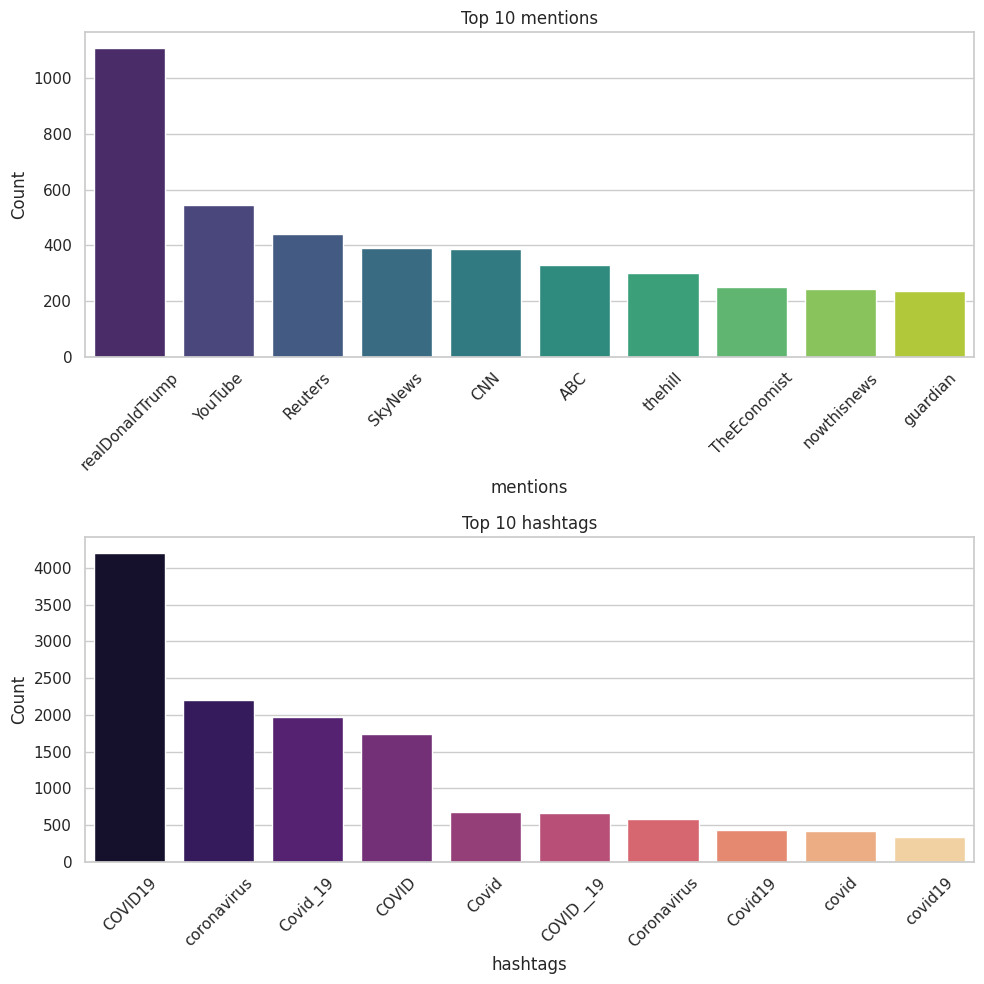

In [ ]:
def top_10_plot(data, text_col, regex, col_name, ax=None, title=None, **kwargs):
    data_with_extracted = data.withColumn(col_name, regexp_extract(col(text_col), regex, 0))
    pattern_counts = data_with_extracted.groupBy(col_name).count()
    top_patterns = pattern_counts.filter(col(col_name) != '').orderBy(col("count").desc()).limit(10)
    top_patterns_pd = top_patterns.toPandas()

    if ax is None:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=col_name, y="count", data=top_patterns_pd, **kwargs)
        plt.title(title if title else f'Top 10 {col_name}')
        plt.xlabel(col_name)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
    else:
        sns.barplot(x=col_name, y="count", data=top_patterns_pd, ax=ax, **kwargs)
        ax.set_title(title if title else f'Top 10 {col_name}')
        ax.set_xlabel(col_name)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

text_col = "tweet"
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot top 10 mentions
top_10_plot(df, text_col, '(?<=@)\w+', 'mentions', ax=axes[0], palette="viridis")

# Plot top 10 hashtags
top_10_plot(df, text_col, '(?<=#)\w+', 'hashtags', ax=axes[1], palette="magma")
plt.tight_layout()
plt.show()


### Labels Count

In [ ]:
label_distribution = df.groupBy('label').count().orderBy('count', ascending=False)
label_distribution_pd = label_distribution.toPandas()
styled_table = label_distribution_pd.style.background_gradient(cmap='magma')
styled_table

,label,count
0,2,79845
1,1,60711
2,0,53193


### Label Count in Pie Chart

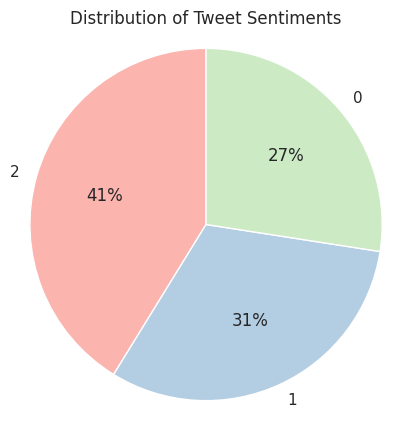

In [ ]:
label_counts = df.groupBy('label').count().orderBy('count', ascending=False)
label_counts_pd = label_counts.toPandas()
labels = label_counts_pd['label']
counts = label_counts_pd['count']


plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, colors=plt.cm.Pastel1.colors, autopct='%.0f%%', startangle=90)
plt.title('Distribution of Tweet Sentiments')
plt.axis('equal')
plt.show()


### Tweets over time

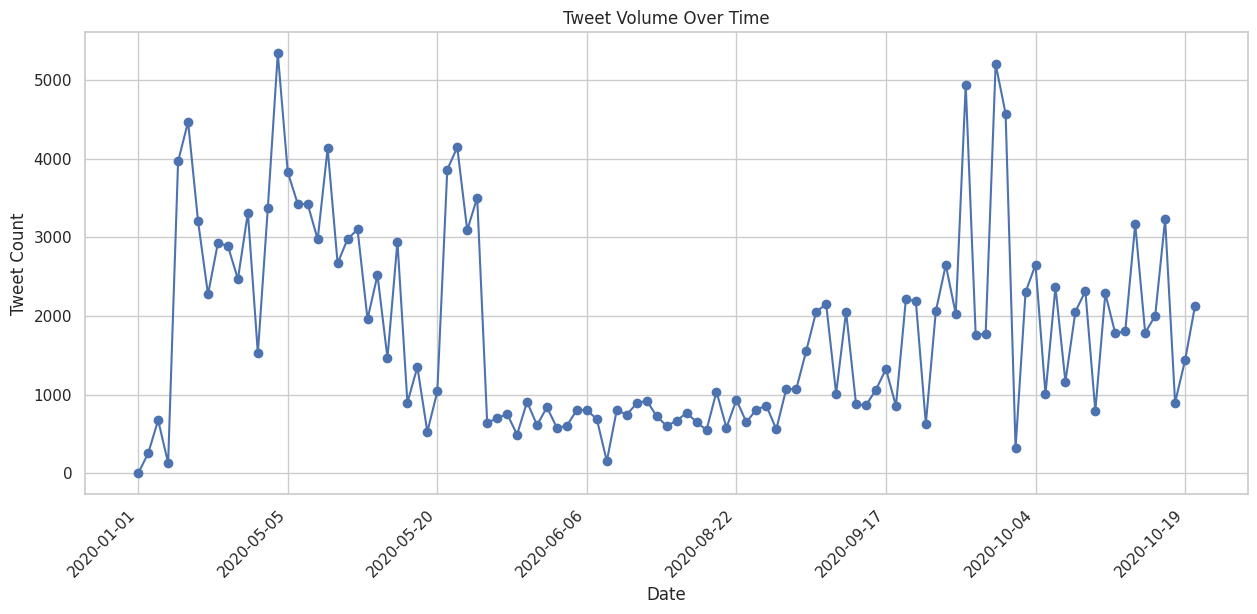

In [ ]:
tweets_df = df.withColumn('date', date_format(col('created_at'), 'yyyy-MM-dd'))
tweet_counts_per_day = tweets_df.groupBy('date').count().orderBy('date')
# Convert Spark DataFrame to Pandas DataFrame
tweet_counts_pd = tweet_counts_per_day.toPandas()
tweet_counts_pd = tweet_counts_pd.dropna(subset=['date', 'count'])
import matplotlib.pyplot as plt

# Plot time-series of tweet volume over time
plt.figure(figsize=(15, 6))
plt.plot(tweet_counts_pd['date'], tweet_counts_pd['count'], marker='o', linestyle='-')
plt.title('Tweet Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')


plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))



### Word Cloud

In [ ]:
from wordcloud import WordCloud

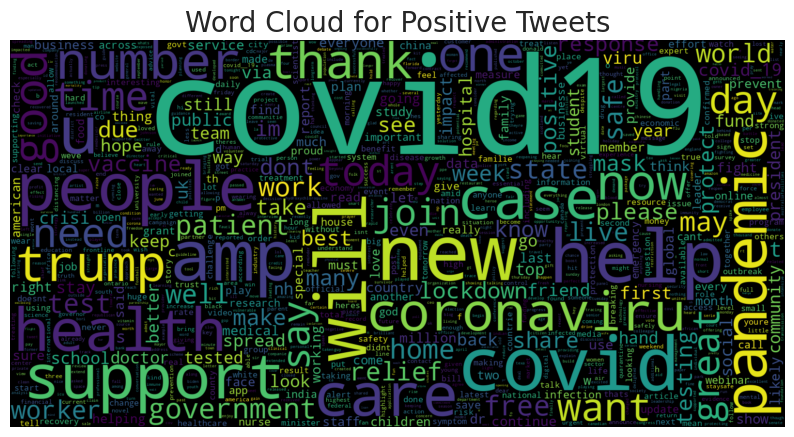

In [ ]:
positive_tweets = df.filter(col('label') == 1).select('tweets').rdd.flatMap(lambda x: x).collect()
positive_text = " ".join(positive_tweets)
wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(positive_text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis
plt.title("Word Cloud for Positive Tweets", fontsize=20)
plt.show()

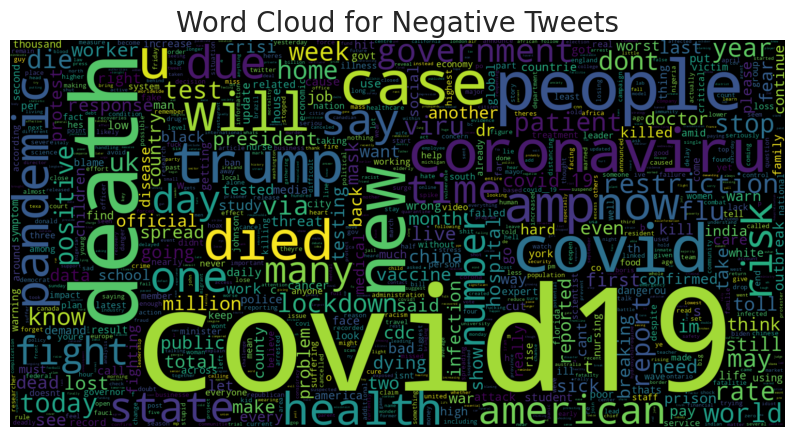

In [ ]:
negative_tweets = df.filter(col('label') == 0).select('tweets').rdd.flatMap(lambda x: x).collect()
positive_text = " ".join(negative_tweets)
wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(positive_text)

# Plot WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis
plt.title("Word Cloud for Negative Tweets", fontsize=20)
plt.show()

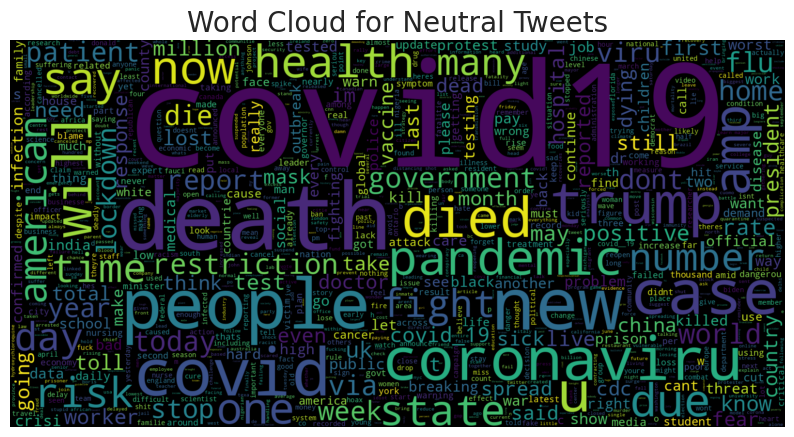

In [ ]:
Neutral_tweets = df.filter(col('label') == 2).select('tweets').rdd.flatMap(lambda x: x).collect()
Neutral_text = " ".join(Neutral_tweets)
wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(positive_text)

# Plot WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis
plt.title("Word Cloud for Neutral Tweets", fontsize=20)
plt.show()

### Most Frequent Words

<ipython-input-239-a1190ce06d51>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.values, y=word_freq.index, ax=axis, palette='viridis')
<ipython-input-239-a1190ce06d51>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.values, y=word_freq.index, ax=axis, palette='viridis')
<ipython-input-239-a1190ce06d51>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.values, y=word_freq.index, ax=axis, palette='viridis')


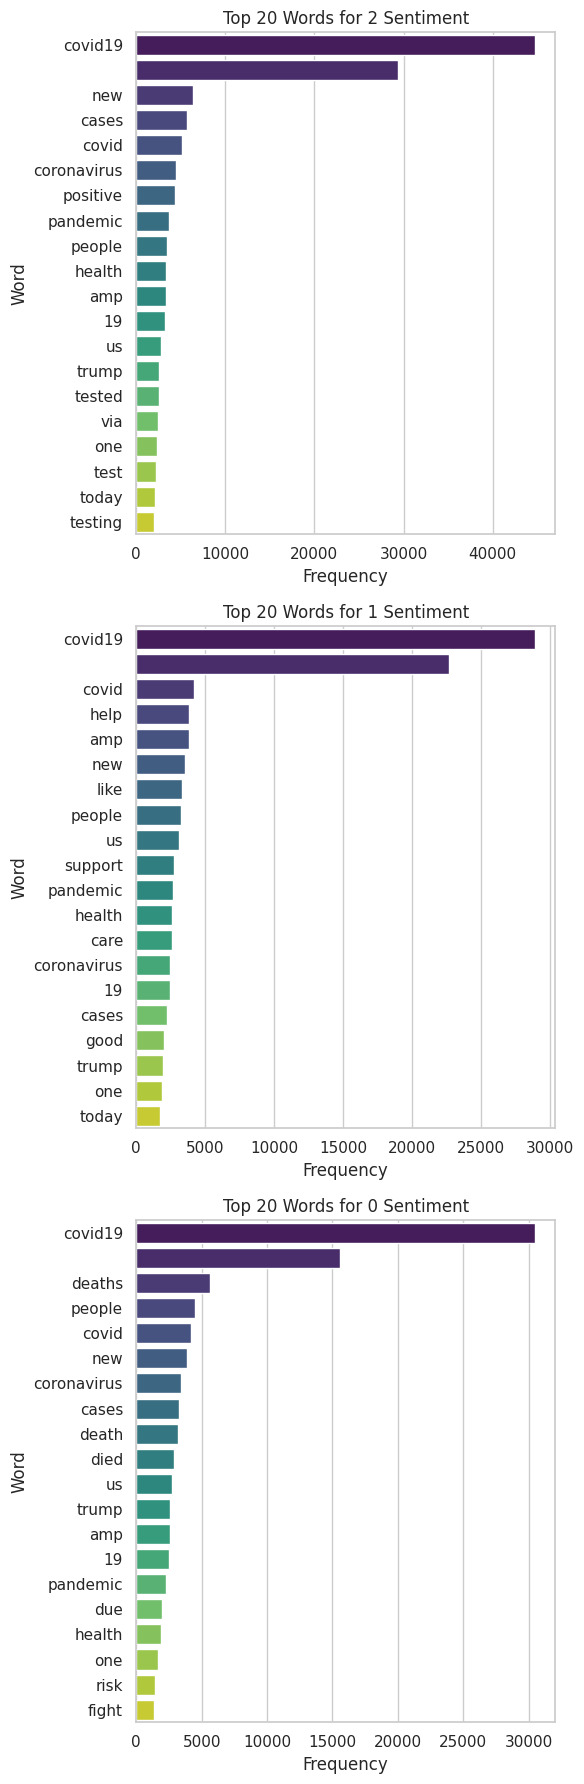

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Word Frequency Analysis") \
    .getOrCreate()

# Assuming 'data' is your Spark DataFrame containing processed text ('processed') and sentiment labels ('target')

# Initialize dictionary to store word counts for each sentiment label
word_counts = {label: [] for label in label_distribution_pd['label']}

# Process text and populate word_counts dictionary
for row in df.select('filtered_words', 'label').collect():
    text = row['filtered_words']
    target = row['label']
    words = text
    word_counts[target].extend(words)

# Create subplots for each sentiment label
fig, axes = plt.subplots(len(word_counts), 1, figsize=(6, 6 * len(word_counts)))

# Iterate over sentiment labels and plot top word counts
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    # Calculate word frequency using Pandas Series
    word_freq = pd.Series(words).value_counts().nlargest(20)

    # Plot bar chart using Seaborn
    sns.barplot(x=word_freq.values, y=word_freq.index, ax=axis, palette='viridis')

    # Set plot title and labels
    axis.set_title(f"Top 20 Words for {target} Sentiment")
    axis.set_xlabel("Frequency")
    axis.set_ylabel("Word")

    # Customize y-axis label rotation for better readability
    for tick in axis.get_yticklabels():
        tick.set_rotation(0)  # Set rotation angle (0 degrees)

# Adjust layout and display plots
plt.tight_layout()
plt.show()


### Distribution of Sentiment Label

<ipython-input-245-dc6aa9821ca5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=distribution_df, palette="viridis")


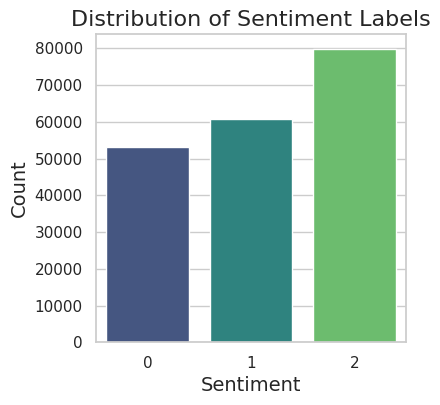

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
label_counts = df.groupBy('label').count().orderBy('label')
distribution_df = label_counts.toPandas()
sns.set(style="whitegrid")

plt.figure(figsize=(4, 4))
sns.barplot(x='label', y='count', data=distribution_df, palette="viridis")
plt.title('Distribution of Sentiment Labels', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

## Model Selection

### Encoding textual dataset

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(df)
featurized_data.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|              tweets|label|              tokens|      filtered_words|         rawFeatures|
+--------------------+-----+--------------------+--------------------+--------------------+
|sticky blood on s...|    1|[sticky, blood, o...|[sticky, blood, s...|(1000,[89,197,204...|
|coronavirus freed...|    1|[coronavirus, fre...|[coronavirus, fre...|(1000,[102,664,80...|
|when covid19 brok...|    0|[when, covid19, b...|[covid19, broke, ...|(1000,[92,117,132...|
|two pet cats in n...|    2|[two, pet, cats, ...|[two, pet, cats, ...|(1000,[1,67,78,20...|
|there is a lot of...|    2|[there, is, a, lo...|[lot, twitter, ch...|(1000,[67,126,248...|
|mississippi barbe...|    1|[mississippi, bar...|[mississippi, bar...|(1000,[216,222,24...|
|a new study sugge...|    1|[a, new, study, s...|[new, study, sugg...|(1000,[89,102,224...|
|covid19 appears t...|    2|[covid19, appears...|[covid19, appears...|(1000,[16,

### Normalizing using IDF

In [ ]:
# Apply IDF to normalize the feature vectors
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data).select("features", "label")
rescaled_data.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                 |label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(1000,[89,197,204,359,682],[4.882667738041133,4.267040337789246,5.922420064049705

### Splitting Dataset

In [ ]:
train_data, test_data = rescaled_data.randomSplit([0.8, 0.2], seed=42)
train_data=train_data.dropna()
test_data=test_data.dropna()
print('Training data: ' ,train_data.count())
print('Testing data: ',test_data.count())

Training data:  155057
Testing data:  38692


### Logistic Regression

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


feature_cols = train_data.columns[:-1]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="result")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)


lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction", "label").show(truncate=False)

+----------+-----+
|prediction|label|
+----------+-----+
|2.0       |0    |
|2.0       |1    |
|2.0       |1    |
|2.0       |2    |
|2.0       |2    |
|2.0       |2    |
|2.0       |2    |
|2.0       |2    |
|0.0       |2    |
|1.0       |2    |
|1.0       |1    |
|1.0       |1    |
|2.0       |1    |
|2.0       |2    |
|2.0       |2    |
|0.0       |0    |
|2.0       |1    |
|0.0       |1    |
|1.0       |0    |
|0.0       |2    |
+----------+-----+
only showing top 20 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
lr_f1_score = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})
print("Accuracy =", lr_accuracy*100)
print("Precision =", lr_precision*100)
print("Recall =", lr_recall*100)
print("F1-score =", lr_f1_score*100)

Accuracy = 63.5299286674248
Precision = 63.79288274972888
Recall = 63.5299286674248
F1-score = 63.09365735574046


#### Coefficient Matrix

In [ ]:
coefficients_matrix = lr_model.coefficientMatrix
print("Coefficient Matrix:")
print(coefficients_matrix)

Coefficient Matrix:
DenseMatrix([[ 0.00601043, -0.06939138,  0.0049494 , ...,  0.07694541,
               0.0177553 ,  0.03247944],
             [ 0.16104352, -0.02845334,  0.03843659, ..., -0.04457778,
              -0.02304792,  0.00416438],
             [-0.16705395,  0.09784472, -0.04338599, ..., -0.03236763,
               0.00529262, -0.03664382]])


### Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

nb = NaiveBayes(featuresCol="features", labelCol="label")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)
nb_predictions.select("label", "prediction", "features").show(truncate=False)


+-----+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|prediction|features                                                                                                                                                                                                                                                                                                                     |
+-----+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
nb_accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
nb_precision = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedPrecision"})
nb_recall = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedRecall"})
nb_f1_score = evaluator.evaluate(nb_predictions, {evaluator.metricName: "f1"})
print("Accuracy =", nb_accuracy*100)
print("Precision =", nb_precision*100)
print("Recall =", nb_recall*100)
print("F1-score =", nb_f1_score*100)

Accuracy = 60.25276542954616
Precision = 60.34578981688556
Recall = 60.25276542954616
F1-score = 60.287153557479115


### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
rf_model = rf.fit(train_data)
rc_predictions = rf_model.transform(test_data)
rc_predictions.select("label", "prediction", "features").show(truncate=False)

+-----+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|prediction|features                                                                                                                                                                                                                                                                                                                     |
+-----+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
rf_accuracy = evaluator.evaluate(rc_predictions, {evaluator.metricName: "accuracy"})
rf_precision = evaluator.evaluate(rc_predictions, {evaluator.metricName: "weightedPrecision"})
rf_recall = evaluator.evaluate(rc_predictions, {evaluator.metricName: "weightedRecall"})
rf_f1_score = evaluator.evaluate(rc_predictions, {evaluator.metricName: "f1"})
print("Accuracy =", rf_accuracy*100)
print("Precision =", rf_precision*100)
print("Recall =", rf_recall*100)
print("F1-score =", rf_f1_score*100)

Accuracy = 46.4695544298563
Precision = 61.425229718069886
Recall = 46.4695544298563
F1-score = 35.916075440207315


### Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_predictions.select("label", "prediction", "features").show(truncate=False)



+-----+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|prediction|features                                                                                                                                                                                                                                                                                                                     |
+-----+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
dt_f1_score = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})
print("Accuracy =", dt_accuracy*100)
print("Precision =", dt_precision*100)
print("Recall =", dt_recall*100)
print("F1-score =", dt_f1_score*100)

Accuracy = 49.79323891243668
Precision = 62.617106068954364
Recall = 49.79323891243668
F1-score = 42.15178098425728


### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) =", rmse)


Root Mean Squared Error (RMSE) = 0.7195011062572334


### Multi Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr_multi = LinearRegression(featuresCol="features", labelCol="label")
lr_multi_model = lr_multi.fit(train_data)
predictions_multi = lr_multi_model.transform(test_data)

# Evaluate the model using RMSE (Root Mean Squared Error)
evaluator_multi = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_multi = evaluator_multi.evaluate(predictions_multi)

print("Root Mean Squared Error (RMSE) for Multi-linear Regression =", rmse_multi)


Root Mean Squared Error (RMSE) for Multi-linear Regression = 0.7195011062572334


### Gradient Descent

In [ ]:
# Using Stochastic Gradient Descent (SGD) optimizer for linear regression
lr_sgd = LinearRegression(featuresCol="features", labelCol="label", solver="l-bfgs")
lr_sgd_model = lr_sgd.fit(train_data)
predictions_sgd = lr_sgd_model.transform(test_data)
evaluator_sgd = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_sgd = evaluator_sgd.evaluate(predictions_sgd)

print("Root Mean Squared Error (RMSE) using Stochastic Gradient Descent (SGD) =", rmse_sgd)


Root Mean Squared Error (RMSE) using Stochastic Gradient Descent (SGD) = 0.7195011067793184


## Final Model Selection
This is classification problem so we compare accuracy of classification models


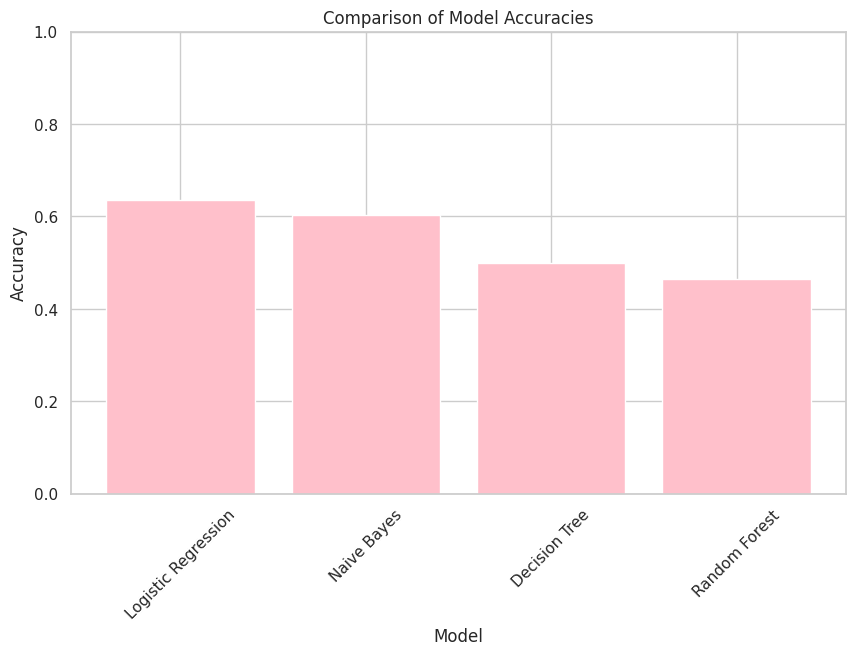

In [ ]:
model_names = ["Logistic Regression", "Naive Bayes","Decision Tree", "Random Forest"]
accuracies = [lr_accuracy, nb_accuracy,dt_accuracy, rf_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='pink')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.show()


#### CONCLUSION

*Logistic Regression* model has been selected keeping in view following points:

 **Logistic Regression Model Performance:**
The Logistic Regression model was trained and evaluated on the dataset using various performance metrics such as accuracy, precision, recall, F1-score, and AUC. The model achieved reasonable performance, achieving an accuracy of **63%**
and demonstrating competitive results across other metrics.

**Comparison with Other Models:**
The Logistic Regression model was compared with other machine learning models, including Decision Trees, Random Forests, and Naive Bayes. Each model's performance was assessed using the same evaluation metrics to ensure a fair comparison.

**Accuracy and Robustness:**
In terms of accuracy, the Logistic Regression model performed comparably well against the other models.

*In summary, the evaluation process has provided valuable insights into the strengths and limitations of the Logistic Regression model compared to alternative approaches. The decision to select this model reflects a holistic consideration of its performance, interpretability, and suitability for the specific use case.*